# Glowによる大規模遺伝子データの分散処理

<table>
  <tr><th>作者</th><th>Databricks Japan</th></tr>
  <tr><td>日付</td><td>2021/07/13</td></tr>
  <tr><td>バージョン</td><td>1.0</td></tr>
  <tr><td>クラスター</td><td>7.3 LTS ML(8.3MLでは動作未確認)</td></tr>
</table>
<img style="margin-top:25px;" src="https://sajpstorage.blob.core.windows.net/workshop20210205/databricks-logo-small-new.png" width="140">

**参考資料**
- [Glow V1\.0\.0 \- 次世代ゲノムワイド分析 \- Qiita](https://qiita.com/taka_yayoi/items/d218797152fa480b6673)
- [Get Started with Glow V1\.0\.0 \- For Next Generation Genome Wide Analytics \- The Databricks Blog](https://databricks.com/blog/2021/03/09/glow-v1-0-0-next-generation-genome-wide-analytics.html)
- [Glow — Glow documentation](https://glow.readthedocs.io/en/latest/index.html)
- [Glow \| Databricks on AWS](https://docs.databricks.com/applications/genomics/genomics-libraries/glow.html)

## 事前準備

**Glowのインストール** クラスターライブラリとして以下の二つをインストールしてください。
- Maven: io.projectglow:glow-spark3_2.12:1.0.0
- PyPI: glow.py==1.0.0

## 人口規模のGWAS(ゲノムワイド関連研究)におけるエンジニアリング

ゲノムワイド関連研究(GWAS)は遺伝子の変数と、関心のある疾病、特性との相関を導き出します。

対照集団は数百万規模に増加しているため、頑健性をもって大規模GWASエンジニアリングを行うための手段が必要となっています。このため、Glowを用いてSparkネイティブの拡張可能な実装を開発したのです。

このノートブックでは[Delta Lake](https://delta.io)による高性能ビッグデータ蓄積機能と、[mlflow](https://mlflow.org/)によるパラメーター、メトリクス、グラフのトラッキング機能を活用しています。

In [0]:
import re
from pyspark.sql.types import * 

# ログインIDからUsernameを取得
username_raw = dbutils.notebook.entry_point.getDbutils().notebook().getContext().tags().apply('user')
# Username の英数字以外を除去し、全て小文字化。Username をファイルパスやデータベース名の一部で使用可能にするため。
username = re.sub('[^A-Za-z0-9]+', '', username_raw).lower()

# ファイル格納パス
work_path = f"dbfs:/tmp/{username}/gwas"
work_path_from_local = f"/dbfs/tmp/{username}/gwas"

print("path: " + work_path)
print("path referred from local API: " + work_path_from_local)

path: dbfs:/tmp/takaakiyayoidatabrickscom/gwas
path referred from local API: /dbfs/tmp/takaakiyayoidatabrickscom/gwas

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pyspark.sql.functions as fx
from pyspark.sql.types import StringType
from pyspark.ml.linalg import Vector, Vectors, SparseVector, DenseMatrix
from pyspark.ml.stat import Summarizer
from pyspark.mllib.linalg.distributed import RowMatrix
from pyspark.mllib.util import MLUtils

from dataclasses import dataclass

import mlflow
import glow

# needed?
#mlflow.set_experiment(f"/Users/{username_raw}/20210713_glow/gwas")
spark = glow.register(spark)

/databricks/python/lib/python3.7/site-packages/patsy/constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
 from collections import Mapping
/databricks/spark/python/pyspark/sql/context.py:77: DeprecationWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
 DeprecationWarning)

### パラメータ

In [0]:
allele_freq_cutoff = 0.05
num_pcs = 5 # 主成分コンポーネントの数
mlflow.log_param("minor allele frequency cutoff", allele_freq_cutoff)
mlflow.log_param("principal components", num_pcs)

### ファイルパス

In [0]:
# データソース
vcf_path = "/databricks-datasets/genomics/1kg-vcfs/ALL.chr22.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz"
phenotype_path = "/databricks-datasets/genomics/1000G/phenotypes.normalized"
sample_info_path = "/databricks-datasets/genomics/1000G/samples/populations_1000_genomes_samples.csv"

# 出力先
delta_silver_path = f"{work_path}/gwas_test/snps.delta"
delta_gold_path = f"{work_path}/gwas_test/snps.qced.delta"
principal_components_path = f"{work_path_from_local}/gwas_test/pcs.csv"
gwas_results_path = f"{work_path}/gwas_test/gwas_results.delta"

### ヘルパー関数

In [0]:
def plot_layout(plot_title, plot_style, xlabel):
  plt.style.use(plot_style) #e.g. ggplot, seaborn-colorblind, print(plt.style.available)
  plt.title(plot_title)
  plt.xlabel(r'${0}$'.format(xlabel))
  plt.gca().spines['right'].set_visible(False)
  plt.gca().spines['top'].set_visible(False)
  plt.gca().yaxis.set_ticks_position('left')
  plt.gca().xaxis.set_ticks_position('bottom')
  plt.tight_layout()
  
def plot_histogram(df, col, xlabel, xmin, xmax, nbins, plot_title, plot_style, color, vline, out_path):
  plt.close()
  plt.figure()
  bins = np.linspace(xmin, xmax, nbins)
  df = df.toPandas()
  plt.hist(df[col], bins, alpha=1, color=color)
  if vline:
    plt.axvline(x=vline, linestyle='dashed', linewidth=2.0, color='black')
  plot_layout(plot_title, plot_style, xlabel)
  plt.savefig(out_path)
  plt.show()
  
def calculate_pval_bonferroni_cutoff(df, cutoff=0.05):
  bonferroni_p =  cutoff / df.count()
  return bonferroni_p

def get_sample_info(vcf_df, sample_metadata_df):
  """
  get sample IDs from VCF dataframe, index them, then join to sample metadata dataframe
  """
  sample_id_list = vcf_df.limit(1).select("genotypes.sampleId").collect()[0].__getitem__("sampleId")
  sample_id_indexed = spark.createDataFrame(sample_id_list, StringType()). \
                            coalesce(1). \
                            withColumnRenamed("value", "Sample"). \
                            withColumn("index", fx.monotonically_increasing_id())
  sample_id_annotated = sample_id_indexed.join(sample_metadata_df, "Sample")
  return sample_id_annotated

## 1000のVCF遺伝子データをDelta Lakeに取り込む

Variant call format (VCF)ファイルをSparkのデータソースとしてクラウドストレージから直接読み込めるGlowのVCFリーダーを用いることで、遺伝子型データを、ACIDトランザクションを有する高性能ビッグデータストアDelta Lakeに書き込みます。Delta Lakeはデータを構造化、インデックス付け、圧縮することで、増加し続ける遺伝子データに対して高性能、高信頼の処理を実現します。

In [0]:
vcf_view_unsplit = (spark.read.format("vcf")
   .option("flattenInfoFields", "false")
   .load(vcf_path))

Split multiallelics variants to biallelics

In [0]:
vcf_view = glow.transform("split_multiallelics", vcf_view_unsplit)

In [0]:
display(vcf_view.withColumn("genotypes", fx.col("genotypes")[0]))

contigName,start,end,names,referenceAllele,alternateAlleles,qual,filters,splitFromMultiAllelic,attributes,INFO_OLD_MULTIALLELIC,genotypes
22,16050074,16050075,List(rs587697622),A,List(G),100.0,List(PASS),false,"Map(AC -> 1, NS -> 2504, AFR_AF -> 0, VT -> SNP, AN -> 5008, SAS_AF -> 0.001, AA -> .|||, AF -> 0.000199681, EAS_AF -> 0, AMR_AF -> 0, DP -> 8012, EUR_AF -> 0)",null,"List(HG00096, true, List(0, 0))"
22,16050114,16050115,List(rs587755077),G,List(A),100.0,List(PASS),false,"Map(AC -> 32, NS -> 2504, AFR_AF -> 0.0234, VT -> SNP, AN -> 5008, SAS_AF -> 0, AA -> .|||, AF -> 0.00638978, EAS_AF -> 0, AMR_AF -> 0.0014, DP -> 11468, EUR_AF -> 0)",null,"List(HG00096, true, List(0, 0))"
22,16050212,16050213,List(rs587654921),C,List(T),100.0,List(PASS),false,"Map(AC -> 38, NS -> 2504, AFR_AF -> 0.0272, VT -> SNP, AN -> 5008, SAS_AF -> 0, AA -> .|||, AF -> 0.00758786, EAS_AF -> 0, AMR_AF -> 0.0014, DP -> 15092, EUR_AF -> 0.001)",null,"List(HG00096, true, List(0, 0))"
22,16050318,16050319,List(rs587712275),C,List(T),100.0,List(PASS),false,"Map(AC -> 1, NS -> 2504, AFR_AF -> 0, VT -> SNP, AN -> 5008, SAS_AF -> 0, AA -> .|||, AF -> 0.000199681, EAS_AF -> 0, AMR_AF -> 0.0014, DP -> 22609, EUR_AF -> 0)",null,"List(HG00096, true, List(0, 0))"
22,16050526,16050527,List(rs587769434),C,List(A),100.0,List(PASS),false,"Map(AC -> 1, NS -> 2504, AFR_AF -> 0, VT -> SNP, AN -> 5008, SAS_AF -> 0, AA -> .|||, AF -> 0.000199681, EAS_AF -> 0, AMR_AF -> 0, DP -> 23591, EUR_AF -> 0.001)",null,"List(HG00096, true, List(0, 0))"
22,16050567,16050568,List(rs587638893),C,List(A),100.0,List(PASS),false,"Map(AC -> 2, NS -> 2504, AFR_AF -> 0, VT -> SNP, AN -> 5008, SAS_AF -> 0, AA -> .|||, AF -> 0.000399361, EAS_AF -> 0.002, AMR_AF -> 0, DP -> 21258, EUR_AF -> 0)",null,"List(HG00096, true, List(0, 0))"
22,16050606,16050607,List(rs587720402),G,List(A),100.0,List(PASS),false,"Map(AC -> 5, NS -> 2504, AFR_AF -> 0, VT -> SNP, AN -> 5008, SAS_AF -> 0, AA -> .|||, AF -> 0.000998403, EAS_AF -> 0, AMR_AF -> 0.0014, DP -> 20274, EUR_AF -> 0.004)",null,"List(HG00096, true, List(0, 0))"
22,16050626,16050627,List(rs587593704),G,List(T),100.0,List(PASS),false,"Map(AC -> 2, NS -> 2504, AFR_AF -> 0, VT -> SNP, AN -> 5008, SAS_AF -> 0.001, AA -> .|||, AF -> 0.000399361, EAS_AF -> 0, AMR_AF -> 0.0014, DP -> 21022, EUR_AF -> 0)",null,"List(HG00096, true, List(0, 0))"
22,16050645,16050646,List(rs587670191),G,List(T),100.0,List(PASS),false,"Map(AC -> 1, NS -> 2504, AFR_AF -> 0, VT -> SNP, AN -> 5008, SAS_AF -> 0.001, AA -> .|||, AF -> 0.000199681, EAS_AF -> 0, AMR_AF -> 0, DP -> 22073, EUR_AF -> 0)",null,"List(HG00096, true, List(0, 0))"
22,16050653,16063474,"List(esv3647175, esv3647176, esv3647177, esv3647178)",A,List(),100.0,List(PASS),true,"Map(AC -> 9,87,599,20, NS -> 2504, AFR_AF -> 0.0061,0.0363,0.0053,0, VT -> SV, AN -> 5008, SAS_AF -> 0,0.0082,0.1094,0.002, AF -> 0.00179712,0.0173722,0.119609,0.00399361, EAS_AF -> 0.001,0.0169,0.2361,0.0099, AMR_AF -> 0,0.0101,0.219,0.0072, DP -> 22545, CS -> DUP_gs, END -> 16063474, EUR_AF -> 0,0.007,0.0944,0.003, SVTYPE -> CNV)",22:16050654:A////,"List(HG00096, true, List(-1, 0))"


**注意** ここでは、Glowに組み込まれている`call_summary_stats`と`hardy_weinberg`を用いてバリアントワイズのサマリー統計情報とハーディー・ワインベルグ平衡のP値を計算します。

**注意** 以下の処理はi3.xlargeの8台ワーカー構成で約19分かかります。

In [0]:
(vcf_view
  .select(
    fx.expr("*"),
    glow.expand_struct(glow.call_summary_stats(fx.col("genotypes"))),
    glow.expand_struct(glow.hardy_weinberg(fx.col("genotypes")))
  )
  .write
  .mode("overwrite")
  .format("delta")
  .save(delta_silver_path))

Delta Lakeに関連づけられているメタデータはトランザクションログに直接保存されているので、Delta Lakeのサイズを容易に計算することができ、これをMLflowに記録することができます。

In [0]:
num_variants = spark.read.format("delta").load(delta_silver_path).count()
mlflow.log_metric("Number Variants pre-QC", num_variants)

### 品質管理の実行

ハーディー・ワインベルグ平衡のP値と対立遺伝子頻度に対するバリアントワイズのフィルタリングを行います。

In [0]:
hwe = (spark.read.format("delta")
                 .load(delta_silver_path)
                 .where((fx.col("alleleFrequencies").getItem(0) >= allele_freq_cutoff) & 
                       (fx.col("alleleFrequencies").getItem(0) <= (1.0 - allele_freq_cutoff)))
                 .withColumn("log10pValueHwe", fx.when(fx.col("pValueHwe") == 0, 26).otherwise(-fx.log10(fx.col("pValueHwe")))))

In [0]:
hwe_cutoff = calculate_pval_bonferroni_cutoff(hwe)
mlflow.log_param("Hardy-Weinberg P value cutoff", hwe_cutoff)

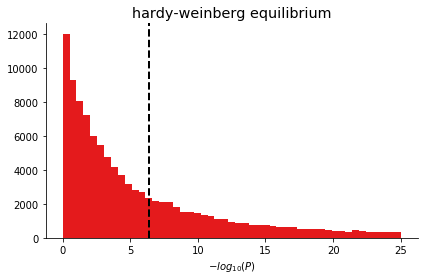

In [0]:
display(plot_histogram(df=hwe.select("log10pValueHwe"), 
                       col="log10pValueHwe",
                       xlabel='-log_{10}(P)',
                       xmin=0, 
                       xmax=25, 
                       nbins=50, 
                       plot_title="hardy-weinberg equilibrium", 
                       plot_style="ggplot",
                       color='#e41a1c',
                       vline = -np.log10(hwe_cutoff),
                       out_path = "/databricks/driver/hwe.png"
                      )
       )

In [0]:
mlflow.log_artifact("/databricks/driver/hwe.png")

In [0]:
(spark.read.format("delta")
   .load(delta_silver_path)
   .where((fx.col("alleleFrequencies").getItem(0) >= allele_freq_cutoff) & 
         (fx.col("alleleFrequencies").getItem(0) <= (1.0 - allele_freq_cutoff)) &
         (fx.col("pValueHwe") >= hwe_cutoff))
   .write
   .mode("overwrite")
   .format("delta")
   .save(delta_gold_path))

In [0]:
num_variants = spark.read.format("delta").load(delta_gold_path).count()
mlflow.log_metric("Number Variants post-QC", num_variants)

### 主成分分析(PCA)の実行

GAWSにおける系統を制御するためのものです。

注意: `array_to_sparse_vector`はGlowに組み込まれている関数です。

In [0]:
vectorized = (spark.read.format("delta")
                        .load(delta_gold_path)
                        .select(glow.array_to_sparse_vector(glow.genotype_states(fx.col("genotypes"))).alias("features"))
                        .cache())

### スパースなベクトルにおいて主成分分析を行うために`pyspark.ml`を使用します

In [0]:
matrix = RowMatrix(MLUtils.convertVectorColumnsFromML(vectorized, "features").rdd.map(lambda x: x.features))
pcs = matrix.computeSVD(num_pcs)

/databricks/spark/python/pyspark/sql/context.py:119: DeprecationWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
 DeprecationWarning)

In [0]:
pd.DataFrame(pcs.V.toArray()).to_csv(principal_components_path)

### サンプル情報を読み込み、主成分のプロットを出力

ここでは、インデックスで両方のデータフレームを結合し、サンプル情報に対して主成分の注釈を付与します。

**注意** インデックスはSpark SQLの`monotonically_increasing_id()`関数を用いて付与します。

In [0]:
pcs_df = spark.createDataFrame(pcs.V.toArray().tolist(), ["pc" + str(i) for i in range(num_pcs)])

In [0]:
sample_metadata = spark.read.option("header", True).csv(sample_info_path)
sample_info = get_sample_info(vcf_view, sample_metadata)
sample_count = sample_info.count()
mlflow.log_param("number of samples", sample_count)
pcs_indexed = pcs_df.coalesce(1).withColumn("index", fx.monotonically_increasing_id())
pcs_with_samples = pcs_indexed.join(sample_info, "index")

### pc1とpc2の散布図プロットを作成するためにdisplay関数を使用します

**注意** ここではchromosome 22しか分析していないため、PCAの散布図は総数と全体のゲノムデータを区別しません。

In [0]:
display(pcs_with_samples)

index,pc0,pc1,pc2,pc3,pc4,Sample,Population,super_population
0,0.01981814499891468,-0.004737618687965962,0.029629997963927797,-0.010262701685650879,0.028474366023685048,HG00096,GBR,EUR
1,0.019583102236291148,-0.009898347332045507,0.023695652609740082,-0.006539953351386399,0.021653401296463523,HG00097,GBR,EUR
2,0.01940503254147367,-0.007290451565030177,0.024936576919761554,0.005406133443608207,0.011686526152967017,HG00099,GBR,EUR
3,0.01961444011177275,-0.004767697375096504,0.02775433673261397,-0.018425634114585494,0.037788421869450445,HG00100,GBR,EUR
4,0.020111215026122935,-0.004625967170798945,0.02187510621974104,-0.021821313906798444,0.023715446736070005,HG00101,GBR,EUR
5,0.019523247279664768,-0.006223273850612581,0.027869207389266515,-0.013142978773499217,0.013100465808372992,HG00102,GBR,EUR
6,0.019167584025287433,-0.007752001069971988,0.027250748218804185,-0.010559300700957954,0.0059293034575113954,HG00103,GBR,EUR
7,0.019382770136583887,-0.00953162595122189,0.029724428763391483,-0.014310606603646026,0.01949569522698752,HG00105,GBR,EUR
8,0.01964627313782825,-0.008564186875276469,0.022189329776533838,-0.014983354607167598,0.016808614333334408,HG00106,GBR,EUR
9,0.019526309485055682,-0.006548334068805328,0.0268720394724487,-0.012150463736321362,0.006932860374774658,HG00107,GBR,EUR


### GAWSのデータ準備

In [0]:
phenotype_df = pd.read_parquet('/dbfs/' + phenotype_path).explode('values').rename({'values': 'bmi'}, axis='columns').reset_index(drop=True)
del phenotype_df['phenotype']
phenotype_df

,bmi
0,26.9
1,24.5
2,32.5
3,25.9
4,25.9
...,...
2499,23.1
2500,25.9
2501,25.9
2502,21.7


In [0]:
covariate_df = pd.read_csv(principal_components_path)

In [0]:
phenotype = phenotype_df.columns[0]
mlflow.log_param("phenotype", phenotype)

In [0]:
genotypes = spark.read.format("delta").load(delta_gold_path)

### `linear_regression`の実行

**注意** `genotype_states`は遺伝子型の配列を変換するGlowのユーティリティ関数です。例えば、`[0,1]`を変異型を含む数(`1`)に変換します。

In [0]:
results = glow.gwas.linear_regression(
  genotypes.select('contigName', 'start', 'names', 'genotypes'),
  phenotype_df,
  covariate_df,
  values_column=glow.genotype_states(fx.col('genotypes'))
)

(results.write
  .format("delta")
  .mode("overwrite")
  .save(gwas_results_path))

### 結果の表示

In [0]:
display(spark.read.format("delta").load(gwas_results_path).limit(100))

contigName,start,names,effect,stderror,tvalue,pvalue,phenotype
22,44665264,List(rs2743846),-0.17867951215703243,0.10817487789781777,-1.6517653232371892,0.0987081867111603,bmi
22,44665407,List(rs35541354),-0.18451960429284547,0.10607892847109414,-1.7394557708331861,0.08207789879753179,bmi
22,44665658,List(rs135418),-0.15469443109933498,0.10913817742731055,-1.417418127605863,0.1564855290119126,bmi
22,44666891,List(rs135416),-0.118695451814232,0.10676691908550862,-1.1117249877667625,0.2663634822389841,bmi
22,44667856,List(rs135413),-0.22559693893422686,0.10924685671624786,-2.0650199531157285,0.03902415808754231,bmi
22,44667881,List(rs139232971),-0.04787217286375999,0.24411346847130866,-0.19610623356239165,0.8445429813400597,bmi
22,44668791,List(rs135412),-0.11950676091961784,0.10617926907940155,-1.1255187755177511,0.2604774770395273,bmi
22,44669980,List(rs135411),-0.14440438544701667,0.10609089149123455,-1.3611383919697544,0.17359282782249005,bmi
22,44670215,List(rs135409),-0.1970544825718015,0.10985043882484317,-1.793843380871745,0.07295916788969815,bmi
22,44671300,List(rs135407),-0.21678077710095017,0.11383082287395678,-1.9044119301587443,0.056971418604782054,bmi


### GWASの結果をRで読み込み、`qqman`ライブラリを用いてプロットします

In [0]:
%r
library(SparkR)
# Cmd10で指定したgwas_results_pathのパスを設定してください
gwas_df <- read.df("/tmp/takaakiyayoidatabrickscom/gwas/gwas_test/gwas_results.delta", source="delta")
gwas_results <- select(gwas_df, c(cast(alias(gwas_df$contigName, "CHR"), "double"), alias(gwas_df$start, "BP"), alias(gwas_df$pValue, "P"), alias(element_at(gwas_df$names, 1L), "SNP")))
gwas_results_rdf <- as.data.frame(gwas_results)

In [0]:
%r
install.packages("qqman", repos="http://cran.us.r-project.org")
library(qqman)

Installing package into ‘/databricks/spark/R/lib’
(as ‘lib’ is unspecified)
also installing the dependency ‘calibrate’

trying URL 'http://cran.us.r-project.org/src/contrib/calibrate_1.7.7.tar.gz'
Content type 'application/x-gzip' length 306782 bytes (299 KB)
==================================================
downloaded 299 KB

trying URL 'http://cran.us.r-project.org/src/contrib/qqman_0.1.8.tar.gz'
Content type 'application/x-gzip' length 1341458 bytes (1.3 MB)
==================================================
downloaded 1.3 MB

* installing *source* package ‘calibrate’ ...
** package ‘calibrate’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** data
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (calibrate)
* installing *source* package ‘qqman’ ...
** package ‘qqman’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** data
*** moving datasets to lazyload DB
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (qqman)

The downloaded source packages are in
	‘/tmp/RtmpAZNAoW/downloaded_packages’

For example usage please run: vignette('qqman')

Citation appreciated but not required:
Turner, (2018). qqman: an R package for visualizing GWAS results using Q-Q and manhattan plots. Journal of Open Source Software, 3(25), 731, https://doi.org/10.21105/joss.00731.

In [0]:
%r
png('/databricks/driver/manhattan.png')
manhattan(gwas_results_rdf, 
          col = c("#228b22", "#6441A5"), 
          chrlabs = NULL,
          suggestiveline = -log10(1e-05), 
          genomewideline = -log10(5e-08),
          highlight = NULL, 
          logp = TRUE, 
          annotatePval = NULL, 
          ylim=c(0,17))
dev.off()

png 
 2

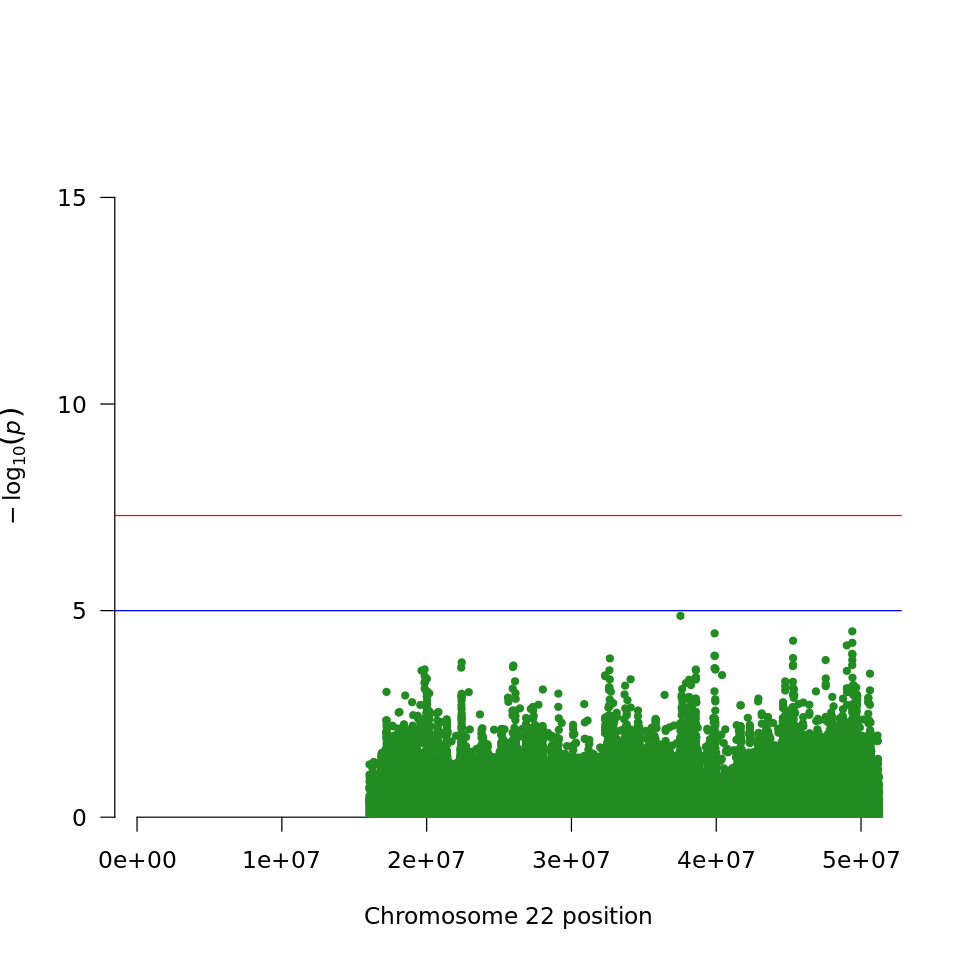

In [0]:
%r
manhattan(gwas_results_rdf, col = c("#228b22", "#6441A5"), chrlabs = NULL,
suggestiveline = -log10(1e-05), genomewideline = -log10(5e-08),
highlight = NULL, logp = TRUE, annotatePval = NULL, ylim=c(0,17))

In [0]:
mlflow.log_artifact('/databricks/driver/manhattan.png')

In [0]:
%r
png('/databricks/driver/qqplot.png')
qq(gwas_results_rdf$P)
dev.off()

png 
 2

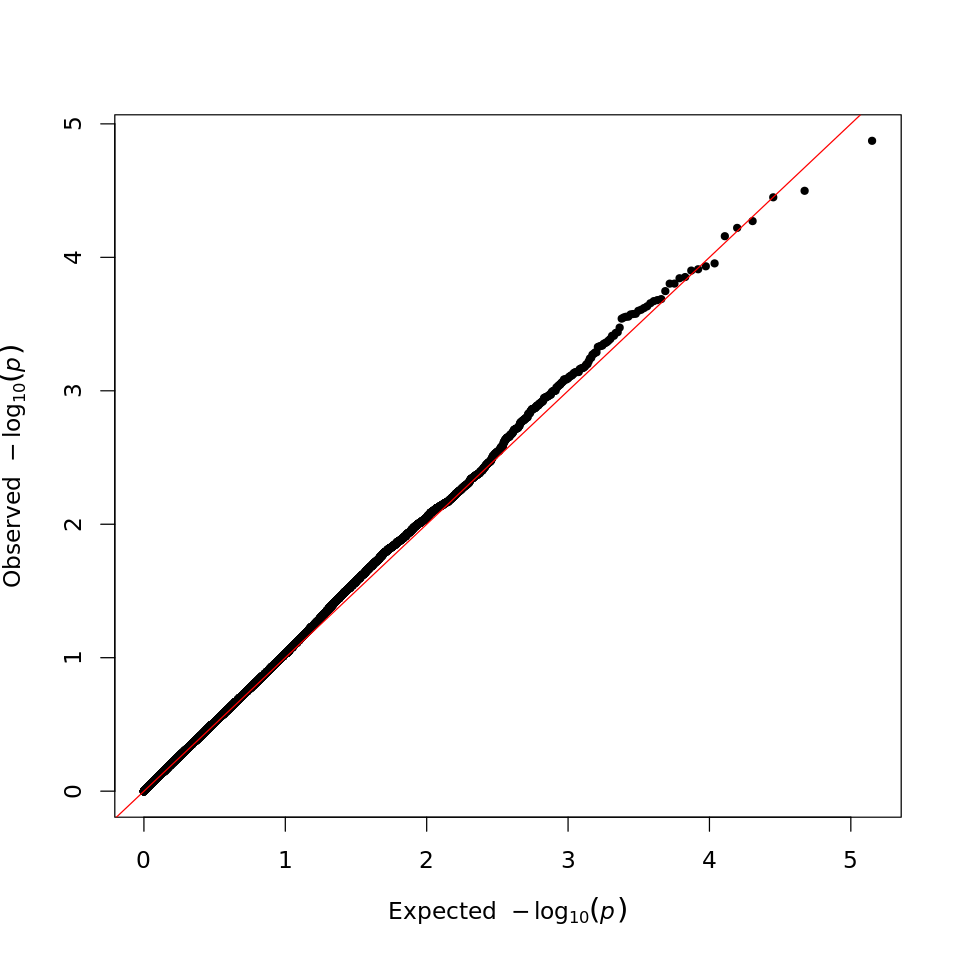

In [0]:
%r
qq(gwas_results_rdf$P)

In [0]:
mlflow.log_artifact('/databricks/driver/qqplot.png')

## Clean up

In [0]:
dbutils.fs.rm(f"{work_path}/gwas_test", True)

Out[31]: True

# END